In [1]:
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


### Step 1: Read data

In [2]:
ds = xr.open_dataset(
    '/g/data/xv83/dbi599/treasury/spei_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_185001-210012.nc',
)

In [3]:
ds

<xarray.Dataset> Size: 671MB
Dimensions:  (lat: 145, lon: 192, time: 3012)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 24kB 1850-01-01 1850-02-01 ... 2100-12-01
Data variables:
    SPEI     (time, lat, lon) float64 671MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T17:33:19Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/6c93c39c-158b-4585-891e-8e011c7fde01
    license:                CMIP6 model data produced by CSIRO is licensed un...

### Step 2: Read shapefiles

In [4]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [5]:
states_gp = states_gp.drop(columns=['AREASQKM21', 'LOCI_URI21'])

In [6]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australian Capital Territory,ACT,"POLYGON ((149.06239 -35.1591, 149.09134 -35.14..."
8,Other Territories,OT,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [7]:
states_gp = states_gp[:-2]

In [8]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."


In [11]:
aus_gp = states_gp.dissolve()
aus_gp['STE_NAME21'] = 'Australia'
aus_gp['ABBREV'] = 'AUS'

In [12]:
aus_gp

,geometry,STE_NAME21,ABBREV
0,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -...",Australia,AUS


In [13]:
states_gp = pd.concat([states_gp, aus_gp], ignore_index=True)

In [14]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australia,AUS,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -..."


We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [15]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [16]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states",
)

In [17]:
type(states_regions)

regionmask.core.regions.Regions

In [18]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory
7 AUS          Australia

[8 regions]


### Step 3: Create a mask

We can use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape:

In [19]:
frac = states_regions.mask_3D_frac_approx(ds)

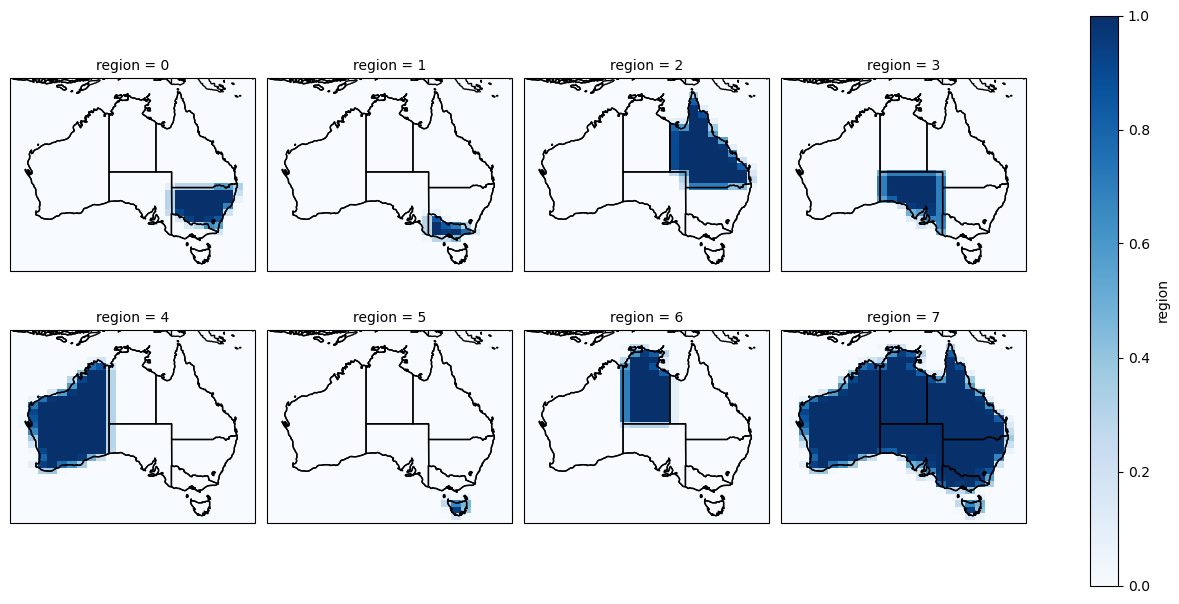

In [20]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

### Final step: Calculate a (weighted) regional mean

In [21]:
weights = np.cos(np.deg2rad(ds['lat']))

The most accurate spatial mean method is to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

In [22]:
spatial_means = ds['SPEI'].weighted(frac * weights).mean(dim=("lat", "lon"))

In [23]:
print(spatial_means)

<xarray.DataArray 'SPEI' (time: 3012, region: 8)> Size: 193kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-2.3589388 , -2.26766093, -2.22122194, ..., -4.01579794,
        -3.28339992, -3.81738153],
       [-2.47401714, -2.62398793, -2.266424  , ..., -3.72121971,
        -3.90039309, -4.33355343],
       [-2.229951  , -3.53147394, -1.83480335, ..., -3.25436766,
        -4.41702562, -4.3963897 ]], shape=(3012, 8))
Coordinates:
  * time     (time) datetime64[ns] 24kB 1850-01-01 1850-02-01 ... 2100-12-01
  * region   (region) int64 64B 0 1 2 3 4 5 6 7
    abbrevs  (region) <U3 96B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT' 'AUS'
    names    (region) <U18 576B 'New South Wales' 'Victoria' ... 'Australia'


In [94]:
#spatial_means.plot(col="region", col_wrap=4)
#plt.show()

In [40]:
df = spatial_means.to_pandas()
df.columns = spatial_means['abbrevs']
df = df.round(decimals=2)

In [41]:
#df['month'] = df.index.month
#df['year'] = df.index.year
#df = df.reset_index()

In [42]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1850-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2100-08-01,-3.18,-3.07,-2.61,-5.85,-5.79,-3.82,-3.33,-4.28
2100-09-01,-2.81,-2.72,-2.39,-4.28,-5.86,-3.98,-3.29,-4.00
2100-10-01,-2.36,-2.27,-2.22,-4.16,-5.66,-4.02,-3.28,-3.82


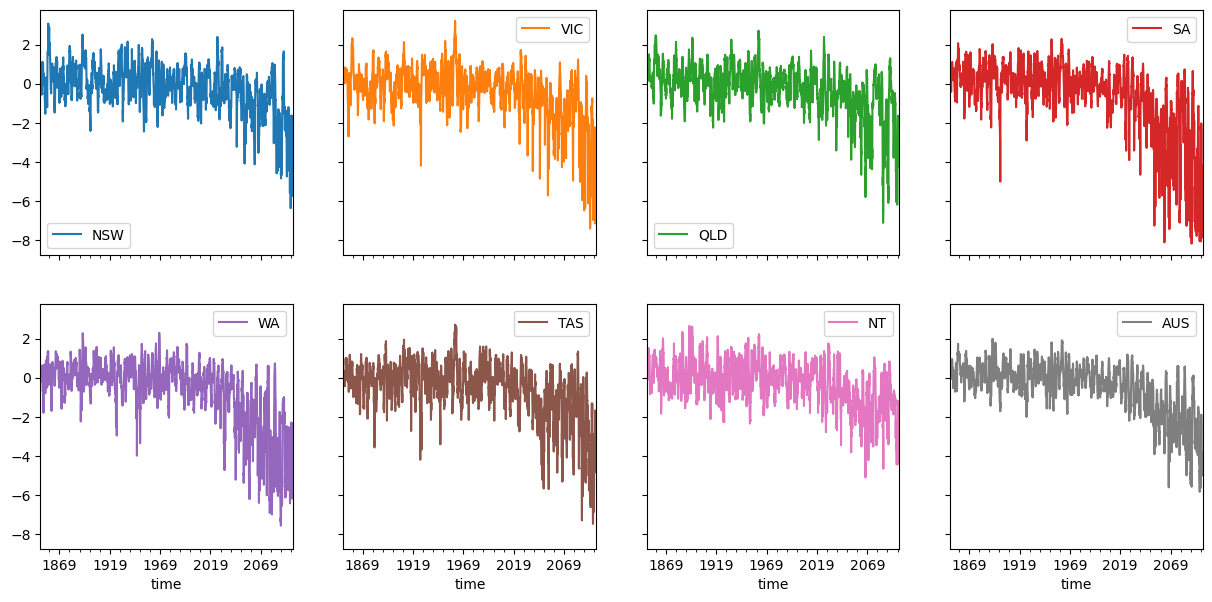

In [43]:
df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [49]:
df.index = df.index.strftime('%Y-%m')

In [51]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1850-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2100-08,-3.18,-3.07,-2.61,-5.85,-5.79,-3.82,-3.33,-4.28
2100-09,-2.81,-2.72,-2.39,-4.28,-5.86,-3.98,-3.29,-4.00
2100-10,-2.36,-2.27,-2.22,-4.16,-5.66,-4.02,-3.28,-3.82


In [53]:
df.to_csv('/g/data/xv83/dbi599/treasury/spei_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1850-2100.csv')